In [1]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# Setting the random seed
# tf.set_random_seed(1)

### 1. (40pts) Define functions

In [2]:

# One hot encode the labels
def one_hot_encode(y):
    enc = pd.get_dummies(y)
    return np.matrix(enc)


# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
    return cost
    

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Initialize the hidden layer and output layer dimensions and apply activations on them
def predict_deep_net(X, inputLayerSize, hiddenLayerSizes, outputLayerSize):
    
    # Random Weight Initialization
    hidden_layer_1 = {'W':tf.Variable(tf.random_normal([inputLayerSize, hiddenLayerSizes[0]])),
                       'b':tf.Variable(tf.random_normal([hiddenLayerSizes[0]]),dtype=tf.float32)}
    
    hidden_layer_2 = {'W':tf.Variable(tf.random_normal([hiddenLayerSizes[0], hiddenLayerSizes[1]])),
                      'b':tf.Variable(tf.random_normal([hiddenLayerSizes[1]]),dtype=tf.float32)}
    
    output_layer = {'W':tf.Variable(tf.random_normal([hiddenLayerSizes[1], outputLayerSize])),
                    'b':tf.Variable(tf.random_normal([outputLayerSize]),dtype=tf.float32)}
    
    layer1 = tf.add(tf.matmul(tf.cast(X, tf.float32),hidden_layer_1['W']), hidden_layer_1['b'])
    layer1 = tf.nn.relu(layer1) # Relu on 1st Hidden Layer
    
    layer2 = tf.add(tf.matmul(layer1,hidden_layer_2['W']), hidden_layer_2['b'])
    layer2 = tf.nn.relu(layer2) # Relu on 2nd Hidden Layer

    output = tf.matmul(layer2,output_layer['W']) + output_layer['b']
    output = tf.nn.sigmoid(output) # Sigmoid on Output Layer
    return output

### 2. Split data

In [3]:
# Reading the training data
data_train = pd.read_csv('ex4_train.csv', sep=",", encoding='utf-8', header='infer')
df_train = data_train.drop('Unnamed: 0',axis=1)

y_train = df_train['y']
X_train = df_train.drop(['y'], axis=1)

X_train_mat = np.matrix(X_train)

25    7
Name: y, dtype: int64


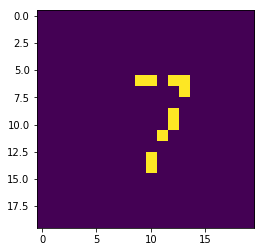

In [4]:
# Reading the test data
data_test = pd.read_csv('ex4_test.csv', sep=",", encoding='utf-8', header='infer')
df_test = data_test.drop('Unnamed: 0',axis=1)
m = df_test.shape[0]

y_test = df_test['y']
X_test = df_test.drop(['y'], axis=1)
X_test_mat = np.matrix(X_test)

# Plot the selected pixel
num = 25
pixels = np.array(X_test[num:num+1], dtype='uint8')
print(y_test[num:num+1])
pixels = pixels.reshape((20, 20)).T
plt.imshow(pixels)
plt.show()

### 3. Define number of neurons in each layer

In [5]:
inputLayerSize = X_train.shape[1]
hiddenLayers = 2
hiddenLayerSizes = [100,40]
outputLayerSize = 10

# One hot encode the labels
y_train_mat = one_hot_encode(y_train)
y_test_mat = one_hot_encode(y_test)

In [6]:
print(y_train.head())
print(y_test.head())

0    4
1    8
2    8
3    0
4    9
Name: y, dtype: int64
0    5
1    7
2    5
3    2
4    9
Name: y, dtype: int64


### 4. (30pts) Neural Network model with 2 hidden layers

In [9]:


def train_deep_neural_net(epochs, X_train, y_train, X_test, y_test):
    x = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    y = tf.placeholder(tf.float32)
    y_pred = predict_deep_net(x, inputLayerSize, hiddenLayerSizes, outputLayerSize)
    cost = get_cost(y, y_pred)
    # The AdamOptimizer is used in place of gradient descent to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            if(epoch % 100 == 0):
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        print('Accuracy Train: ', accuracy.eval({x:X_train, y:y_train}))
        print('Accuracy Test: ', accuracy.eval({x:X_test, y:y_test}))
        

train_deep_neural_net(1000, X_train_mat, y_train_mat, X_test_mat, y_test_mat)

Cost is 2.34882 for iteration: 0
Cost is 1.57419 for iteration: 100
Cost is 1.55188 for iteration: 200
Cost is 1.54839 for iteration: 300
Cost is 1.54673 for iteration: 400
Cost is 1.54665 for iteration: 500
Cost is 1.54665 for iteration: 600
Cost is 1.54625 for iteration: 700
Cost is 1.50625 for iteration: 800
Cost is 1.49736 for iteration: 900
Accuracy Train:  0.953714
Accuracy Test:  0.904667
